In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import io
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import itertools 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle

In [ ]:
x_train = []
y_train  = [] 
x_test = []
y_test = []

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

imagesize = 150

for label in labels:
    trainPath = os.path.join('drive/MyDrive/MRI Dataset/Training', label)
    for file in tqdm(os.listdir(trainPath)):
        img = cv2.imread(os.path.join(trainPath , file))
        img = cv2.resize(img,(imagesize , imagesize))
        x_train.append(img)
        y_train.append(labels.index(label))

    testPath = os.path.join('drive/MyDrive/MRI Dataset/Testing', label)
    for file in tqdm(os.listdir(testPath)):
        img = cv2.imread(os.path.join(testPath , file))
        img = cv2.resize(img,(imagesize , imagesize))
        x_test.append(img)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

100%|██████████| 74/74 [00:25<00:00,  2.88it/s]


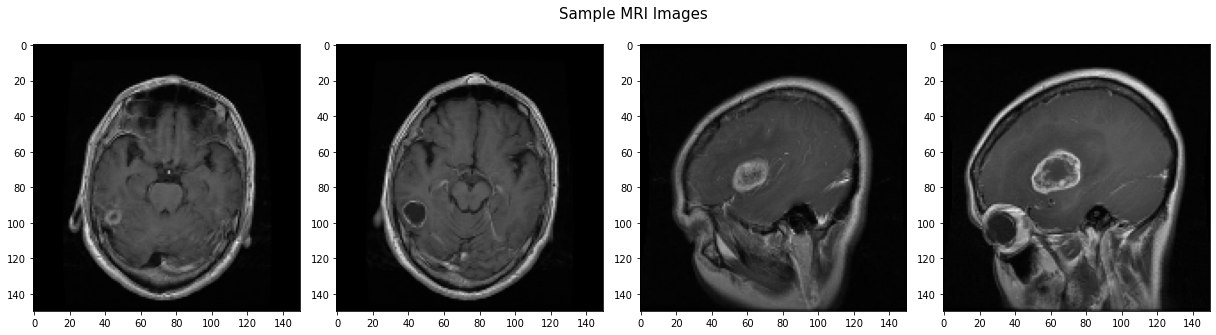

In [ ]:
images = [x_train[i] for i in range(150)]
fig, ax = plt.subplots(1,4,figsize=(17,17))
ax = ax.flatten()
fig.text(s='Sample MRI Images', size=15, y=0.63, x=0.46, alpha=1)
for img, x in zip(images, ax):
    x.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
x_train.shape

(2889, 150, 150, 3)

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=101)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [ ]:
efnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(imagesize, imagesize, 3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model = efnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(rate=0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=efnet.input, outputs = model)

In [ ]:
# adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("efnet.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
final = model.fit(x_train, y_train, batch_size=20, validation_data=(x_val, y_val), epochs = 30,
                    callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.8004
Epoch 1: val_accuracy improved from -inf to 0.12457, saving model to efnet.h5
130/130 [==============================] - 33s 122ms/step - loss: 0.5213 - accuracy: 0.8004 - val_loss: 3.0464 - val_accuracy: 0.1246 - lr: 0.0010
Epoch 2/30
130/130 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9146
Epoch 2: val_accuracy did not improve from 0.12457
130/130 [==============================] - 13s 99ms/step - loss: 0.2480 - accuracy: 0.9146 - val_loss: 4.1981 - val_accuracy: 0.1246 - lr: 0.0010
Epoch 3/30
130/130 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9423
Epoch 3: val_accuracy did not improve from 0.12457

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
130/130 [==============================] - 13s 100ms/step - loss: 0.1545 - accuracy: 0.9423 - val_loss: 2.8739 - val_accuracy: 0.1246 - lr: 0.0010
Epoch 4/30
130/

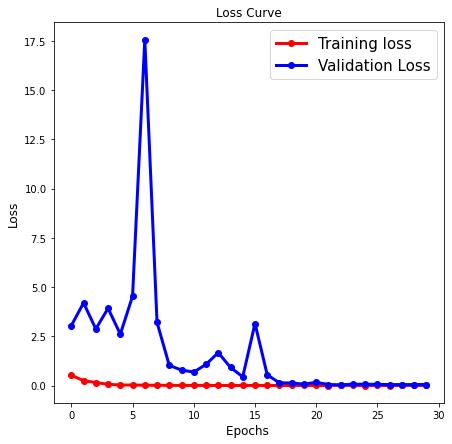

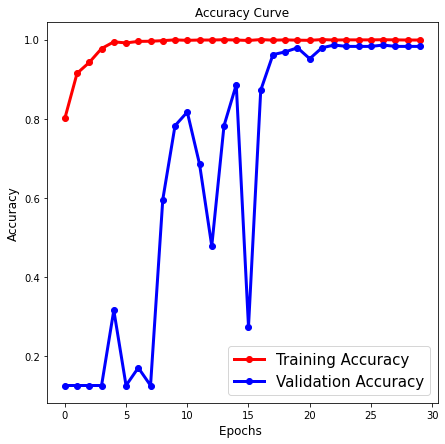

In [ ]:
plt.figure(figsize=[7,7])
plt.plot(final.history['loss'], 'r', marker='o',linewidth=3.0)
plt.plot(final.history['val_loss'], 'b', marker='o',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=15)
plt.xlabel('Epochs ', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curve', fontsize=12)
plt.show()

plt.figure(figsize=[7,7])
plt.plot(final.history['accuracy'], 'r', marker='o', linewidth=3.0)
plt.plot(final.history['val_accuracy'],'b', marker='o', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=15)
plt.xlabel('Epochs ', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curve', fontsize=12)   
plt.show()

In [ ]:
trainpred = model.predict(x_train)
trainpred = np.argmax(trainpred,axis=1)
y1 = np.argmax(y_train, axis=1)
print(classification_report(y1, trainpred, target_names=labels))

valpred = model.predict(x_val)
valpred = np.argmax(valpred,axis=1)
y2 = np.argmax(y_val, axis=1)
print(classification_report(y2, valpred, target_names=labels))

82/82 [==============================] - 5s 36ms/step
                  precision    recall  f1-score   support

    glioma_tumor       1.00      1.00      1.00       738
        no_tumor       1.00      1.00      1.00       363
meningioma_tumor       1.00      1.00      1.00       756
 pituitary_tumor       1.00      1.00      1.00       743

        accuracy                           1.00      2600
       macro avg       1.00      1.00      1.00      2600
    weighted avg       1.00      1.00      1.00      2600

10/10 [==============================] - 1s 65ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.99      0.98        88
        no_tumor       1.00      0.94      0.97        36
meningioma_tumor       0.99      0.98      0.98        81
 pituitary_tumor       0.98      1.00      0.99        84

        accuracy                           0.98       289
       macro avg       0.99      0.98      0.98       289
    weighted avg 

In [ ]:
loss, acc = model.evaluate(x_val, y_val)

10/10 [==============================] - 0s 41ms/step - loss: 0.0534 - accuracy: 0.9827


In [ ]:
model.save('classTumor2.h5')

In [ ]:
model.optimizer.get_config() 

{'name': 'Adam',
 'learning_rate': 6.561e-08,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
testpred = model.predict(x_test)
testpred = np.argmax(testpred,axis=1)
y3 = np.argmax(y_test, axis=1)
print(classification_report(y3, testpred, target_names=labels))


13/13 [==============================] - 0s 36ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.26      0.41       100
        no_tumor       0.77      0.98      0.87       105
meningioma_tumor       0.70      1.00      0.82       115
 pituitary_tumor       1.00      0.92      0.96        74

        accuracy                           0.79       394
       macro avg       0.85      0.79      0.76       394
    weighted avg       0.83      0.79      0.75       394



In [ ]:
loss, acc = model.evaluate(x_test, y_test)

13/13 [==============================] - 1s 39ms/step - loss: 1.4872 - accuracy: 0.7919


In [ ]:
model.save('classTumor2.h5')

In [ ]:
from __future__ import division, print_function
import sys
import os
import glob
import re
import numpy as np

# Keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image


img_path = '/content/download.jpg'
img = keras.utils.load_img(img_path, target_size=(150, 150))

    # Preprocessing the image
x = keras.utils.img_to_array(img)
x = np.true_divide(x, 255)
x = np.expand_dims(x, axis=0)

    # Be careful how your trained model deals with the input
    # otherwise, it won't make correct prediction!

preds = model.predict(x)
pred_class = preds.argmax()  
print(preds, pred_class)

1/1 [==============================] - 0s 28ms/step
[[4.9640923e-05 1.2434132e-02 9.8728895e-01 2.2727651e-04]] 2
